In [1]:
import sys
import os
sys.path.append(os.environ["HOME"]+"/.local/lib/python3.9/site-packages")

import scanpy as sc, anndata as ad
import harmonypy
import leidenalg

In [2]:
import os
import scanpy as sc, anndata as ad
sc.logging.print_versions()

-----
anndata     0.9.1
scanpy      1.9.3
-----
PIL                 8.3.1
anyio               NA
attr                21.2.0
babel               2.9.1
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
bottleneck          1.3.2
brotli              NA
certifi             2022.12.07
cffi                1.14.6
chardet             4.0.0
charset_normalizer  2.0.0
cloudpickle         1.6.0
colorama            0.4.6
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.06.2
dateutil            2.8.2
debugpy             1.6.7
decorator           5.0.9
defusedxml          0.7.1
entrypoints         0.3
fastjsonschema      NA
fsspec              2021.07.0
google              NA
h5py                3.3.0
harmonypy           NA
idna                3.1
igraph              0.11.5
ipykernel           6.17.1
ipython_genutils    0.2.0
jedi                0.18.0
jinja2              3.0.1
joblib              1.0.1
json5               NA
j

In [6]:
%%bash
ls /home/jlyoung/CSE185_Proj/data

GSE167880_features.tsv.gz
GSM5114462_S6_B3_barcodes.tsv.gz
GSM5114462_S6_B3_features.tsv.gz
GSM5114462_S6_B3_matrix.mtx.gz
GSM5114465_S7_D25_barcodes.tsv.gz
GSM5114465_S7_D25_features.tsv.gz
GSM5114465_S7_D25_matrix.mtx.gz
GSM5114475_M6_CTRL_barcodes.tsv.gz
GSM5114475_M6_CTRL_features.tsv.gz
GSM5114475_M6_CTRL_matrix.mtx.gz
test_andata.ipynb


In [7]:
DATADIR=os.environ["HOME"]+"/CSE185_Proj/data"
dsets = ["GSM5114462_S6_B3", "GSM5114465_S7_D25", "GSM5114475_M6_CTRL"]
adatas = {}
for ds in dsets:
    print(ds)
    adatas[ds] = sc.read_10x_mtx(DATADIR, prefix=ds+"_", cache=True)
combined = ad.concat(adatas, label="dataset")
combined.obs_names_make_unique()

GSM5114462_S6_B3
GSM5114465_S7_D25
GSM5114475_M6_CTRL


/opt/conda/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [15]:
## print dataset dimensions
#combined
#adatas["GSM5114462_S6_B3"]
#adatas["GSM5114465_S7_D25"]
#adatas["GSM5114475_M6_CTRL"]

## print cell info
#combined.obs

In [14]:
# Initial filtering
sc.pp.filter_cells(combined, min_counts=1000)
sc.pp.filter_cells(combined, min_genes=200)
sc.pp.filter_genes(combined, min_counts=15)
sc.pp.filter_genes(combined, min_cells=5)

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


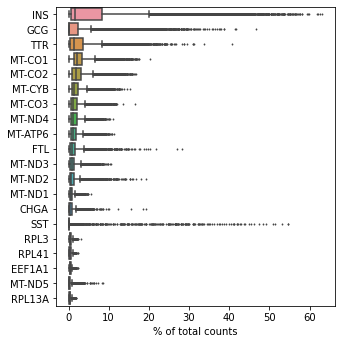

In [16]:
# Filtering cells with high mitochondria gene expression

sc.pl.highest_expr_genes(combined, n_top=20)

In [17]:
# annotate the group of mitochondrial genes as "mt"
combined.var["mt"] = combined.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    combined, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

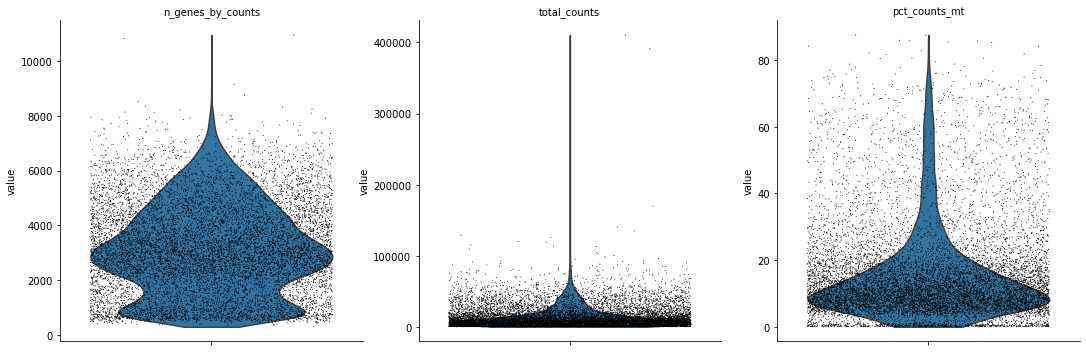

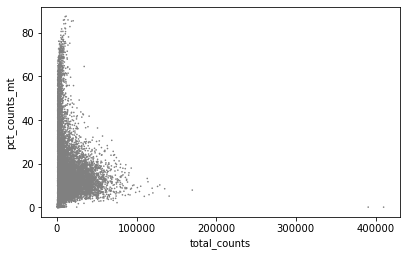

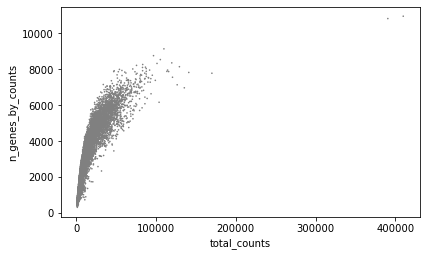

In [19]:
sc.pl.violin(
    combined,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)
sc.pl.scatter(combined, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(combined, x="total_counts", y="n_genes_by_counts")

In [20]:
adata_filt = combined[(combined.obs["n_genes_by_counts"]<8000) & (combined.obs["pct_counts_mt"]<40), :]

In [21]:
#adata_filt
#adata_filt.obs

,dataset,n_counts,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCTGAGCCACGCT,GSM5114462_S6_B3,2374.0,1065,1065,2374.0,386.0,16.259478
AAACCTGAGTGACTCT,GSM5114462_S6_B3,4586.0,2134,2133,4585.0,254.0,5.539804
AAACCTGAGTGTACGG,GSM5114462_S6_B3,12197.0,3447,3447,12197.0,738.0,6.050668
AAACCTGCAATAGCGG,GSM5114462_S6_B3,16071.0,3514,3514,16071.0,719.0,4.473897
AAACCTGGTTCAGACT,GSM5114462_S6_B3,12613.0,2749,2748,12612.0,1245.0,9.871551
...,...,...,...,...,...,...,...
TTTGGTTGTCAGGTAG,GSM5114475_M6_CTRL,29978.0,4294,4291,29975.0,4137.0,13.801501
TTTGTTGAGTAATACG,GSM5114475_M6_CTRL,7261.0,2729,2729,7261.0,435.0,5.990910
TTTGTTGCAAACAGGC,GSM5114475_M6_CTRL,27166.0,4416,4415,27165.0,3374.0,12.420394
TTTGTTGGTGCCTTCT,GSM5114475_M6_CTRL,2705.0,951,950,2704.0,258.0,9.541420


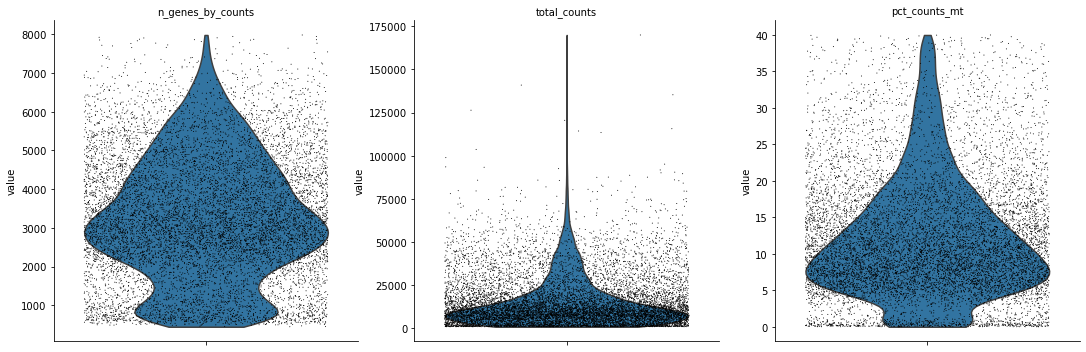

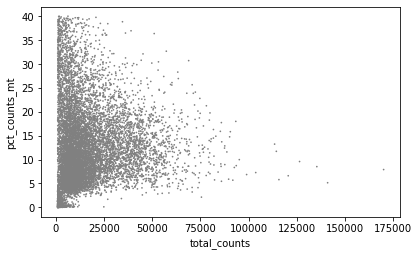

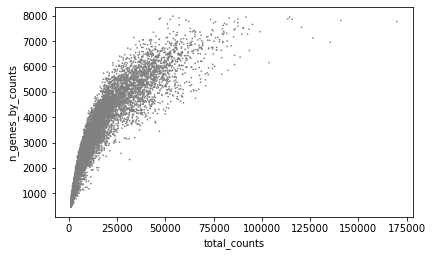

In [22]:
sc.pl.violin(
    adata_filt,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)
sc.pl.scatter(adata_filt, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata_filt, x="total_counts", y="n_genes_by_counts")

In [23]:
## Identifying highly variable genes
sc.pp.normalize_per_cell(adata_filt, counts_per_cell_after=1e4) # normalize to 10,000 reads/cell
sc.pp.log1p(adata_filt) # log transform

/opt/conda/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [24]:
adata_filt.var

,n_counts,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
SAMD11,5518.0,1834,False,1834,0.479910,84.049400,5518.0
NOC2L,4868.0,3518,False,3518,0.423378,69.403374,4868.0
KLHL17,487.0,467,False,467,0.042355,95.938424,487.0
PLEKHN1,57.0,50,False,50,0.004957,99.565142,57.0
HES4,4929.0,2200,False,2200,0.428683,80.866238,4929.0
...,...,...,...,...,...,...,...
AC011043.1,9040.0,5147,False,5147,0.786224,55.235693,9040.0
AC007325.4,3233.0,2384,False,2384,0.281179,79.265959,3233.0
AC007325.2,183.0,173,False,173,0.015916,98.495391,183.0
AC004556.3,17.0,17,False,17,0.001479,99.852148,17.0


In [25]:
sc.pp.highly_variable_genes(adata_filt, batch_key="dataset", n_top_genes=500)

genes = ["GCG", "TTR",  "IAPP",  "GHRL", "PPY", "COL3A1",
    "CPA1", "CLPS", "REG1A", "CTRB1", "CTRB2", "PRSS2", "CPA2", "KRT19", "INS","SST","CELA3A", "VTCN1"]

adata_var = adata_filt[:, (adata_filt.var.index.isin(genes) | adata_filt.var["highly_variable"])]

In [26]:
adata_var.var

,n_counts,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
HES4,4929.0,2200,False,2200,0.428683,80.866238,4929.0,True,0.285543,1.422118,1.781736,1,False
ISG15,7412.0,2422,False,2422,0.644634,78.935467,7412.0,True,0.399567,2.221944,4.093362,2,False
HES5,448.0,76,False,76,0.038963,99.339015,448.0,True,0.034378,1.472533,1.884032,1,False
NPPB,117.0,21,False,21,0.010176,99.817360,117.0,True,0.006155,1.503004,2.654938,2,False
CELA2A,885.0,162,False,162,0.076970,98.591059,885.0,True,0.082321,1.479910,2.040113,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
MX1,1916.0,1036,False,1036,0.166638,90.989737,1916.0,True,0.128660,1.232515,1.584854,1,False
TFF3,105943.0,7422,False,7422,9.214037,35.449643,105943.0,True,1.983392,4.079974,2.534006,1,False
TFF2,55142.0,2060,False,2060,4.795791,82.083841,55142.0,True,1.099970,3.814760,2.724747,2,False
TFF1,32328.0,1617,False,1617,2.811620,85.936685,32328.0,True,0.950185,3.768883,4.018797,2,False


In [27]:
num_highly_variable_genes = sum(adata_var.var['highly_variable'])
print("Number of highly variable genes:", num_highly_variable_genes)

sorted_var = adata_var.var.sort_values(by='dispersions_norm', ascending=False)

top_5_variable_genes = sorted_var.head(5)
print("Top 5 most variable genes:")
print(top_5_variable_genes)

Number of highly variable genes: 500
Top 5 most variable genes:
       n_counts  n_cells     mt  n_cells_by_counts  mean_counts  \
GHRL    63040.0     1658  False               1658     5.482693   
PPY     24175.0     1542  False               1542     2.102540   
NTS      7672.0      703  False                703     0.667246   
MT1G     2183.0      207  False                207     0.189859   
ITLN1    3122.0      414  False                414     0.271525   

       pct_dropout_by_counts  total_counts  highly_variable     means  \
GHRL               85.580101       63040.0             True  1.680951   
PPY                86.588972       24175.0             True  1.075275   
NTS                93.885893        7672.0             True  0.381210   
MT1G               98.199687        2183.0             True  0.169612   
ITLN1              96.399374        3122.0             True  0.261888   

       dispersions  dispersions_norm  highly_variable_nbatches  \
GHRL      7.598976         1

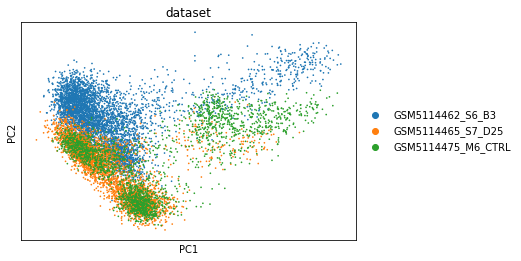

In [30]:
# Removing batch effects

sc.pp.pca(adata_var, n_comps=20)
sc.pl.pca(adata_var, color="dataset")

In [31]:
# Import the "external" library
import scanpy.external as sce

# Run harmony using suggested params from the paper
sce.pp.harmony_integrate(adata_var, 'dataset', theta=2, nclust=50,  max_iter_harmony = 10,  max_iter_kmeans=10)

# Reset the original PCs to those computed by Harmony
adata_var.obsm['X_pca'] = adata_var.obsm['X_pca_harmony']

2024-05-20 20:21:45,181 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2024-05-20 20:21:48,828 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2024-05-20 20:21:49,196 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2024-05-20 20:21:55,097 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2024-05-20 20:22:00,892 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2024-05-20 20:22:07,293 - harmonypy - INFO - Iteration 4 of 10
Iteration 4 of 10
2024-05-20 20:22:13,093 - harmonypy - INFO - Iteration 5 of 10
Iteration 5 of 10
2024-05-20 20:22:20,089 - harmonypy - INFO - Iteration 6 of 10
Iteration 6 of 10
2024-05-20 20:22:26,190 - harmonypy - INFO - Iteration 7 of 10
Iteration 7 of 10
2024-05-20 20:22:31,989 - harmonypy - INFO - Iteration 8 of 10
Iteration 8 of 10
2024-05-20 20:22:37,986 - harmonypy - INFO - Iteration 9 of 10
Iteration 9 of 10

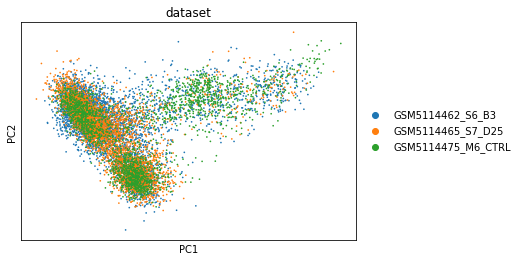

In [32]:
# Plot PCA after batch correction
sc.pl.pca(adata_var, color="dataset")

In [33]:
# Visualizing cell clusters
sc.pp.neighbors(adata_var) # computes neighborhood graphs. Needed to run clustering.
sc.tl.leiden(adata_var) # clusters cells based on expression profiles. This is needed to color cells by cluster.

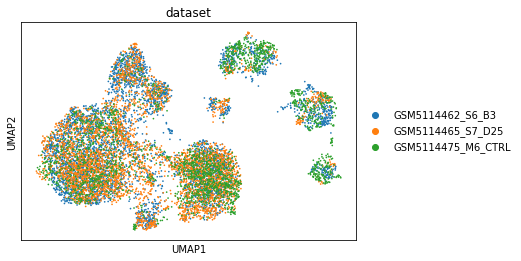

In [34]:
# UMAP

sc.tl.umap(adata_var) # compute UMAP embedding
sc.pl.umap(adata_var, color="dataset") # make the UMAP plot

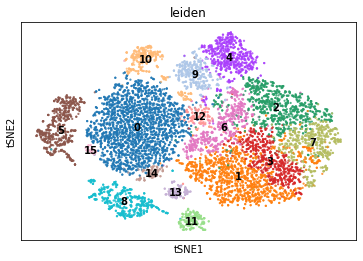

In [39]:
#tSNE

#sc.tl.tsne(adata_var, perplexity=10.0)
sc.pl.tsne(adata_var, color=['leiden'], legend_loc='on data', legend_fontsize=10, alpha=0.8, size=20)

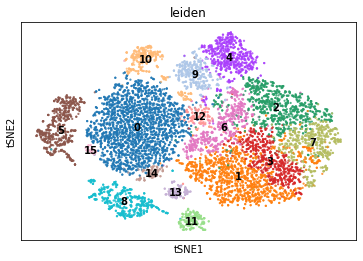

In [40]:
#tSNE

#sc.tl.tsne(adata_var, perplexity=30.0)
sc.pl.tsne(adata_var, color=['leiden'], legend_loc='on data', legend_fontsize=10, alpha=0.8, size=20)

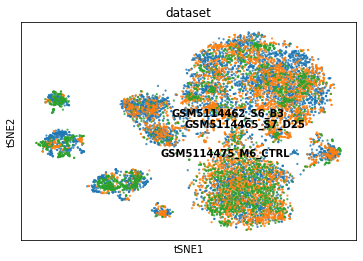

In [37]:
#tSNE

sc.tl.tsne(adata_var, perplexity=50.0)
sc.pl.tsne(adata_var, color=['dataset'], legend_loc='on data', legend_fontsize=10, alpha=0.8, size=20)